#### Problem Statement

Banks invest significant resources into outbound marketing campaigns, like calling customers to offer term deposit products. However, these campaigns can be inefficient, contacting many customers who are not interested, leading to:

- High operational costs

- Low conversion rates

- Customer fatigue and churn risk

1. This project seeks to optimize marketing effectiveness by:

2. Segmenting customers based on their financial and demographic behavior

3. Predicting which customers are most likely to subscribe to a term deposit

4. Designing a targeting strategy that reduces wasted outreach while maximizing ROI


**Stakeholders**

|Stakeholder              | What they care About
|-------------------------|------------------------
|Marketing Team           |Improve campaign efficiency and ROI; avoid over-contacting customers|
Data Science Team         |Build interpretable, reliable models with business impact
Compliance/Legal          |Ensure targeting practices are fair, non-discriminatory
Sales / Call Center       |Focus effort on the right customers; increase success rates
Senior Management         |Strategic insights on customer behavior and product interest


#### Imports

Import the required libraries

In [76]:
import pandas as pd
import zipfile
import urllib.request
import io
import os
from google.cloud import bigquery

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


### Loading dataset

Dataset is from Google [Big Query](https://console.cloud.google.com/bigquery?ws=!1m4!1m3!3m2!1sbigquery-public-data!2sthelook_ecommerce).
A function was writen to obtain the tables in the dataset. The ecommerce data has `7` tables namely:  "distribution_centers", "events", "inventory_items", "order_items", "orders", "products", "users".

In [2]:

client = bigquery.Client(project="testing-469722")

def load_thelook_tables(dataset_id="bigquery-public-data.thelook_ecommerce", table_names=None):
    """
    Load multiple tables from thelook_ecommerce dataset into separate DataFrames.

    Parameters:
        dataset_id (str): Full BigQuery dataset path
        table_names (list): List of table names to load

    Returns:
        dict: Dictionary of {table_name: DataFrame}
    """
    if table_names is None:
        table_names = [
            "distribution_centers",
            "events",
            "inventory_items",
            "order_items",
            "orders",
            "products",
            "users"
        ]

    dataframes = {}

    for table in table_names:
        query = f"SELECT * FROM `{dataset_id}.{table}`"
        df = client.query(query).to_dataframe()
        dataframes[table] = df
        print(f"Loaded {table}: {df.shape[0]} rows")

    return dataframes

### Load the dataset

The dataset are pulled from Big query.


In [3]:
thelook_dfs = load_thelook_tables()

C:\Users\DELL XPS\virtual\dsb_602\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Loaded distribution_centers: 10 rows
Loaded events: 2420913 rows
Loaded inventory_items: 487931 rows
Loaded order_items: 180875 rows
Loaded orders: 124769 rows
Loaded products: 29120 rows
Loaded users: 100000 rows


### Accessing the tables


In [4]:
# order table

orders_df = thelook_dfs['orders']
orders_df.head(4)

,order_id,user_id,status,gender,created_at,returned_at,shipped_at,delivered_at,num_of_item
0,21,15,Cancelled,F,2025-05-27 02:03:00+00:00,NaT,NaT,NaT,2
1,30,22,Cancelled,F,2025-06-20 10:39:00+00:00,NaT,NaT,NaT,1
2,40,26,Cancelled,F,2021-04-28 13:41:00+00:00,NaT,NaT,NaT,2
3,45,29,Cancelled,F,2023-06-08 03:09:00+00:00,NaT,NaT,NaT,1


**orders_df table dictionary**

| Column Name    | Description                                                           |
| -------------- | --------------------------------------------------------------------- |
| `order_id`     | Unique identifier for each order                                      |
| `user_id`      | Foreign key that links to the customer (`users.id`)                   |
| `status`       | Status of the order (e.g., `Complete`, `Returned`, `Cancelled`)       |
| `gender`       | Gender of the customer (from the `users` table, if joined)            |
| `created_at`   | Timestamp when the order was placed                                   |
| `returned_at`  | Timestamp when the item was returned (null if not returned)           |
| `shipped_at`   | Timestamp when the item was shipped                                   |
| `delivered_at` | Timestamp when the item was delivered to the customer                 |
| `num_of_item`  | Number of individual items in that order (usually from `order_items`) |


In [5]:
# distribution_centers

distribution_df = thelook_dfs['distribution_centers']
distribution_df.head(5)

,id,name,latitude,longitude,distribution_center_geom
0,6,Port Authority of New York/New Jersey NY/NJ,40.6340,-73.7834,POINT(-73.7834 40.634)
1,4,Los Angeles CA,34.0500,-118.2500,POINT(-118.25 34.05)
2,8,Mobile AL,30.6944,-88.0431,POINT(-88.0431 30.6944)
3,2,Chicago IL,41.8369,-87.6847,POINT(-87.6847 41.8369)
4,10,Savannah GA,32.0167,-81.1167,POINT(-81.1167 32.0167)


**distribution_df dictionary**

| Column Name                | Description                                                                 |
| -------------------------- | --------------------------------------------------------------------------- |
| `id`                       | Unique identifier for each distribution center                              |
| `name`                     | City and state abbreviation of the distribution center location             |
| `latitude`                 | Latitude coordinate of the distribution center (for mapping or distance)    |
| `longitude`                | Longitude coordinate of the distribution center                             |
| `distribution_center_geom` | Geometry field representing the center as a geographic point (GeoJSON-like) |


In [6]:
events_df = thelook_dfs['events']
events_df.head(5)

,id,user_id,sequence_number,session_id,created_at,ip_address,city,state,postal_code,browser,traffic_source,uri,event_type
0,1574405,<NA>,3,bdac379f-844d-4b41-a1ac-ae97c20f5cb1,2019-07-04 05:15:00+00:00,161.89.190.206,São Paulo,São Paulo,02675-031,Chrome,Facebook,/cancel,cancel
1,1900822,<NA>,3,286de1ce-fbfe-452c-9608-ac9ecb31075d,2020-07-26 11:34:00+00:00,167.57.229.160,São Paulo,São Paulo,02675-031,Firefox,Adwords,/cancel,cancel
2,1969181,<NA>,3,28b49f98-3856-4bba-82ce-a14368399d00,2019-03-15 14:49:00+00:00,141.27.61.40,São Paulo,São Paulo,02675-031,Safari,Organic,/cancel,cancel
3,1953020,<NA>,3,1ff75d98-efc9-4be2-85cb-e3e1c8c821ce,2020-02-08 05:59:00+00:00,14.172.57.122,São Paulo,São Paulo,02675-031,Chrome,Email,/cancel,cancel
4,1531818,<NA>,3,d62abc95-91a5-48cd-9c01-89f59ffec934,2021-09-02 16:48:00+00:00,35.210.30.163,São Paulo,São Paulo,02675-031,Firefox,Email,/cancel,cancel


**events_df dictionary**

| Column Name       | Description                                                           |
| ----------------- | --------------------------------------------------------------------- |
| `id`              | Unique identifier for each event record                               |
| `user_id`         | ID of the user associated with the event *(can be missing/anonymous)* |
| `sequence_number` | Order of the event within a session (helps track user journey)        |
| `session_id`      | Unique ID for the user session (used to group related events)         |
| `created_at`      | Timestamp when the event occurred                                     |
| `ip_address`      | User’s IP address at the time of the event                            |
| `city`            | City of the user (inferred from IP)                                   |
| `state`           | State of the user (inferred from IP)                                  |
| `postal_code`     | Postal code of the user (inferred from IP)                            |
| `browser`         | Browser used by the user (e.g., Chrome, Safari)                       |
| `traffic_source`  | Source that led the user to the site (e.g., Organic, Email, Adwords)  |
| `uri`             | Specific page or endpoint visited (e.g., `/cancel`)                   |
| `event_type`      | Type of user action or event (e.g., `cancel`, `purchase`, `checkout`) |


In [7]:
inventoryitems_df = thelook_dfs['inventory_items']
inventoryitems_df.head()

,id,product_id,created_at,sold_at,cost,product_category,product_name,product_brand,product_retail_price,product_department,product_sku,product_distribution_center_id
0,46517,13844,2025-05-09 16:11:16+00:00,2025-06-06 13:17:16+00:00,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
1,46518,13844,2024-12-12 13:54:00+00:00,NaT,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
2,82719,13844,2021-09-20 12:04:50+00:00,2021-11-16 16:01:50+00:00,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
3,82720,13844,2021-04-06 08:26:00+00:00,NaT,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
4,352717,13844,2025-06-02 17:08:22+00:00,2025-06-14 08:22:22+00:00,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7


**inventoryitems_df dictionary**

| Column Name                      | Description                                                                                                 |
| -------------------------------- | ----------------------------------------------------------------------------------------------------------- |
| `id`                             | Unique identifier for each inventory record                                                                 |
| `product_id`                     | ID of the product listed in the inventory                                                                   |
| `created_at`                     | Timestamp when the product was added to inventory                                                           |
| `sold_at`                        | Timestamp when the product was sold (null if unsold)                                                        |
| `cost`                           | Cost to the business for this unit (wholesale price)                                                        |
| `product_category`               | Category label for the product (e.g., *Jumpsuits & Rompers*)                                                |
| `product_name`                   | Full name or title of the product                                                                           |
| `product_brand`                  | Brand/manufacturer of the product                                                                           |
| `product_retail_price`           | Suggested retail price or sale price to customer                                                            |
| `product_department`             | Department the product belongs to (e.g., *Women*)                                                           |
| `product_sku`                    | Unique stock keeping unit (SKU) for inventory tracking                                                      |
| `product_distribution_center_id` | Foreign key linking to the distribution center where the item is stocked (join with `distribution_centers`) |


In [8]:
orderitems_df = thelook_dfs['order_items']
orderitems_df.head(5)

,id,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price
0,55148,37886,30319,14235,148686,Cancelled,2025-08-28 05:19:35+00:00,NaT,NaT,NaT,0.02
1,100507,69230,55530,14235,270947,Complete,2023-07-22 18:08:02+00:00,2023-07-20 18:15:00+00:00,2023-07-21 06:27:00+00:00,NaT,0.02
2,140698,97045,77874,14235,379402,Complete,2023-07-22 11:03:26+00:00,2023-07-19 04:25:00+00:00,2023-07-20 01:55:00+00:00,NaT,0.02
3,11178,7720,6221,14235,30191,Returned,2020-12-15 15:17:06+00:00,2020-12-18 07:14:00+00:00,2020-12-18 14:49:00+00:00,2020-12-19 09:49:00+00:00,0.02
4,67899,46628,37314,14235,183154,Shipped,2025-03-27 00:43:44+00:00,2025-03-27 03:22:00+00:00,NaT,NaT,0.02


**orderitems_df**

| Column Name         | Description                                                                    |
| ------------------- | ------------------------------------------------------------------------------ |
| `id`                | Unique identifier for each order item (line item)                              |
| `order_id`          | Foreign key referencing the `orders` table (represents the main order)         |
| `user_id`           | ID of the customer who placed the order                                        |
| `product_id`        | ID of the product ordered (from `products` or `inventories` table)             |
| `inventory_item_id` | Foreign key linking to the specific item in the inventory (from `inventories`) |
| `status`            | Status of the item within the order: `Complete`, `Cancelled`, etc.             |
| `created_at`        | Timestamp when the item was added to the order                                 |
| `shipped_at`        | Timestamp when the item was shipped                                            |
| `delivered_at`      | Timestamp when the item was delivered                                          |
| `returned_at`       | Timestamp if the item was returned                                             |
| `sale_price`        | Price at which the item was sold to the customer                               |


In [9]:
products_df = thelook_dfs['products']
products_df.head(5)

,id,cost,category,name,brand,retail_price,department,sku,distribution_center_id
0,13842,2.51875,Accessories,Low Profile Dyed Cotton Twill Cap - Navy W39S55D,MG,6.25,Women,EBD58B8A3F1D72F4206201DA62FB1204,1
1,13928,2.33835,Accessories,Low Profile Dyed Cotton Twill Cap - Putty W39S55D,MG,5.95,Women,2EAC42424D12436BDD6A5B8A88480CC3,1
2,14115,4.87956,Accessories,Enzyme Regular Solid Army Caps-Black W35S45D,MG,10.99,Women,EE364229B2791D1EF9355708EFF0BA34,1
3,14157,4.64877,Accessories,Enzyme Regular Solid Army Caps-Olive W35S45D (...,MG,10.99,Women,00BD13095D06C20B11A2993CA419D16B,1
4,14273,6.50793,Accessories,Washed Canvas Ivy Cap - Black W11S64C,MG,15.99,Women,F531DC20FDE20B7ADF3A73F52B71D0AF,1


**products_df**

| Column Name              | Description                                                                                                      |
| ------------------------ | ---------------------------------------------------------------------------------------------------------------- |
| `id`                     | Unique product ID                                                                                                |
| `cost`                   | Internal cost of the product for the retailer                                                                    |
| `category`               | Product category (e.g., Accessories, Tops, Shoes)                                                                |
| `name`                   | Full name or description of the product                                                                          |
| `brand`                  | Brand or manufacturer of the product                                                                             |
| `retail_price`           | Recommended retail price for the product                                                                         |
| `department`             | Department the product belongs to (e.g., Women, Men, Kids)                                                       |
| `sku`                    | Stock Keeping Unit: unique code used to identify and track inventory                                             |
| `distribution_center_id` | Foreign key linking to the `distribution_centers` table, indicating where the product is stocked or shipped from |


In [10]:
users_df = thelook_dfs['users']
users_df.head(5)

,id,first_name,last_name,email,age,gender,state,street_address,postal_code,city,country,latitude,longitude,traffic_source,created_at,user_geom
0,6769,Timothy,Herman,timothyherman@example.com,37,M,Acre,66068 James Gateway,69980-000,null,Brasil,-8.065346,-72.870949,Search,2024-09-28 13:24:00+00:00,POINT(-72.87094866 -8.065346116)
1,26739,Alexis,Hernandez,alexishernandez@example.org,31,F,Acre,3348 Brenda Mills,69980-000,null,Brasil,-8.065346,-72.870949,Email,2025-08-15 01:19:00+00:00,POINT(-72.87094866 -8.065346116)
2,75610,Kristin,Chavez,kristinchavez@example.org,63,F,Acre,6872 Virginia Curve,69980-000,null,Brasil,-8.065346,-72.870949,Facebook,2024-11-15 10:03:00+00:00,POINT(-72.87094866 -8.065346116)
3,63702,Lance,Gordon,lancegordon@example.net,57,M,Acre,860 Ramirez Extensions Apt. 764,69980-000,null,Brasil,-8.065346,-72.870949,Search,2020-08-20 15:47:00+00:00,POINT(-72.87094866 -8.065346116)
4,771,Thomas,Castillo,thomascastillo@example.net,44,M,Acre,5549 Gonzales Route,69980-000,null,Brasil,-8.065346,-72.870949,Search,2022-12-22 09:22:00+00:00,POINT(-72.87094866 -8.065346116)


**users_df dictionary**

  | Column Name      | Description                                                                                |
| ---------------- | ------------------------------------------------------------------------------------------ |
| `id`             | Unique identifier for the user (primary key)                                               |
| `first_name`     | User's first name                                                                          |
| `last_name`      | User's last name                                                                           |
| `email`          | User's email address                                                                       |
| `age`            | Age of the user                                                                            |
| `gender`         | Gender of the user (`M`, `F`, or other)                                                    |
| `state`          | State of residence (e.g., Acre)                                                            |
| `street_address` | Full street address of the user                                                            |
| `postal_code`    | Postal or ZIP code                                                                         |
| `city`           | City (some entries may be `null`)                                                          |
| `country`        | Country of residence (e.g., Brasil)                                                        |
| `latitude`       | Latitude coordinate of the user's address                                                  |
| `longitude`      | Longitude coordinate of the user's address                                                 |
| `traffic_source` | Original acquisition source (e.g., Facebook, Email, Search, Organic)                       |
| `created_at`     | Timestamp of when the user was created in the system                                       |
| `user_geom`      | Spatial data point combining `longitude` and `latitude` (for mapping and geospatial joins) |


### Data Cleaning & Exploration

#### orders_df

In [11]:
# number of colums
orders_df.shape

(124769, 9)

In [12]:
# Check data type of the orders_df

orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124769 entries, 0 to 124768
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   order_id      124769 non-null  Int64              
 1   user_id       124769 non-null  Int64              
 2   status        124769 non-null  object             
 3   gender        124769 non-null  object             
 4   created_at    124769 non-null  datetime64[us, UTC]
 5   returned_at   12579 non-null   datetime64[us, UTC]
 6   shipped_at    81134 non-null   datetime64[us, UTC]
 7   delivered_at  43868 non-null   datetime64[us, UTC]
 8   num_of_item   124769 non-null  Int64              
dtypes: Int64(3), datetime64[us, UTC](4), object(2)
memory usage: 8.9+ MB


In [13]:
# Check for null values

orders_df.isnull().sum()

order_id             0
user_id              0
status               0
gender               0
created_at           0
returned_at     112190
shipped_at       43635
delivered_at     80901
num_of_item          0
dtype: int64

In [14]:
orders_df['status'].unique()

array(['Cancelled', 'Complete', 'Processing', 'Returned', 'Shipped'],
      dtype=object)

In [15]:
orders_df['status'].value_counts(normalize = True)

status
Shipped       0.298680
Complete      0.250775
Processing    0.200418
Cancelled     0.149308
Returned      0.100818
Name: proportion, dtype: float64

In [16]:
# unique values and proportion of items in gender

orders_df['gender'].value_counts(normalize = True)

gender
F    0.501463
M    0.498537
Name: proportion, dtype: float64

In [17]:
orders_df.describe()

,order_id,user_id,num_of_item
count,124769.0,124769.0,124769.0
mean,62385.0,50018.981702,1.449679
std,36017.852206,28884.137472,0.802674
min,1.0,1.0,1.0
25%,31193.0,24958.0,1.0
50%,62385.0,50046.0,1.0
75%,93577.0,75037.0,2.0
max,124769.0,100000.0,4.0


**distribution_df (Distribution center)**

**Null values interpretation**

The order_df has 112122 null valued for returned_at, this indicates that 112122 were not returned, 43852 were never shipped, and 81210 has no delivery time, perhaps because they were never delivered. This could include:

- Orders that were cancelled before delivery.

- Orders that are still in transit.

- Orders that were lost or failed delivery.

**Status Value counts**

About 29.85% of orders were shipped but not yet marked as delivered, 25.14 were succesfully delivered, 19.92 % are currenly been processed, 15.11 % were cancelled before completion and 9.96 orders were delivered by returned by customers. 

**Gender**

`50.06` % of customers are Male and  `49.93` are female

**.decribe**

50% media of all orders contain 1 item and 75% of order contain 2 items and the maximum number of items ordered in a single order is 4

In [18]:
distribution_df.head()

,id,name,latitude,longitude,distribution_center_geom
0,6,Port Authority of New York/New Jersey NY/NJ,40.6340,-73.7834,POINT(-73.7834 40.634)
1,4,Los Angeles CA,34.0500,-118.2500,POINT(-118.25 34.05)
2,8,Mobile AL,30.6944,-88.0431,POINT(-88.0431 30.6944)
3,2,Chicago IL,41.8369,-87.6847,POINT(-87.6847 41.8369)
4,10,Savannah GA,32.0167,-81.1167,POINT(-81.1167 32.0167)


In [19]:
# no of rows and columns
distribution_df.shape

(10, 5)

In [20]:
# check for null values

distribution_df.isnull().sum()

id                          0
name                        0
latitude                    0
longitude                   0
distribution_center_geom    0
dtype: int64

In [21]:
distribution_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        10 non-null     Int64  
 1   name                      10 non-null     object 
 2   latitude                  10 non-null     float64
 3   longitude                 10 non-null     float64
 4   distribution_center_geom  10 non-null     object 
dtypes: Int64(1), float64(2), object(2)
memory usage: 542.0+ bytes


**events_df**

In [22]:
# number of rows in the table
events_df.shape

(2420913, 13)

In [23]:
events_df.head(5)

,id,user_id,sequence_number,session_id,created_at,ip_address,city,state,postal_code,browser,traffic_source,uri,event_type
0,1574405,<NA>,3,bdac379f-844d-4b41-a1ac-ae97c20f5cb1,2019-07-04 05:15:00+00:00,161.89.190.206,São Paulo,São Paulo,02675-031,Chrome,Facebook,/cancel,cancel
1,1900822,<NA>,3,286de1ce-fbfe-452c-9608-ac9ecb31075d,2020-07-26 11:34:00+00:00,167.57.229.160,São Paulo,São Paulo,02675-031,Firefox,Adwords,/cancel,cancel
2,1969181,<NA>,3,28b49f98-3856-4bba-82ce-a14368399d00,2019-03-15 14:49:00+00:00,141.27.61.40,São Paulo,São Paulo,02675-031,Safari,Organic,/cancel,cancel
3,1953020,<NA>,3,1ff75d98-efc9-4be2-85cb-e3e1c8c821ce,2020-02-08 05:59:00+00:00,14.172.57.122,São Paulo,São Paulo,02675-031,Chrome,Email,/cancel,cancel
4,1531818,<NA>,3,d62abc95-91a5-48cd-9c01-89f59ffec934,2021-09-02 16:48:00+00:00,35.210.30.163,São Paulo,São Paulo,02675-031,Firefox,Email,/cancel,cancel


In [24]:
#check data types
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2420913 entries, 0 to 2420912
Data columns (total 13 columns):
 #   Column           Dtype              
---  ------           -----              
 0   id               Int64              
 1   user_id          Int64              
 2   sequence_number  Int64              
 3   session_id       object             
 4   created_at       datetime64[us, UTC]
 5   ip_address       object             
 6   city             object             
 7   state            object             
 8   postal_code      object             
 9   browser          object             
 10  traffic_source   object             
 11  uri              object             
 12  event_type       object             
dtypes: Int64(3), datetime64[us, UTC](1), object(9)
memory usage: 247.0+ MB


In [25]:
#check for null values

events_df.isnull().sum()

id                       0
user_id            1125011
sequence_number          0
session_id               0
created_at               0
ip_address               0
city                     0
state                    0
postal_code              0
browser                  0
traffic_source           0
uri                      0
event_type               0
dtype: int64

In [26]:
# For user who are not logged in, what kind of events did they generate and how often 

events_df[events_df['user_id'].isnull()]['event_type'].value_counts(normalize = True)

event_type
product       0.444440
cart          0.222456
department    0.222009
cancel        0.111094
Name: proportion, dtype: float64

In [27]:
events_df['event_type'].unique()

array(['cancel', 'cart', 'department', 'home', 'product', 'purchase'],
      dtype=object)

**events_df breakdown**
  
The event table likely captures website /app user behaviour such as clicks, page visists and cancellations. user_id has 1125736 null values which could be customers who visited as guests, or people who simply did not sign in. 

Each website visitor, either signed in or not performs certain actions which are 'cancel', 'cart', 'department', 'home', 'product', 'purchase'"

**Why event type is important**

These event types are valuable for:

- Funnel analysis (home → department → product → cart → purchase)

- Drop-off analysis (e.g., many reach cart but few purchase)

- Engagement segmentation (users who only browse vs. those who purchase)

- Personalization and recommendation logic

**inventoryitems_df**

In [28]:
# number of columns and rows
inventoryitems_df.shape

(487931, 12)

In [29]:
# check data type
inventoryitems_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487931 entries, 0 to 487930
Data columns (total 12 columns):
 #   Column                          Non-Null Count   Dtype              
---  ------                          --------------   -----              
 0   id                              487931 non-null  Int64              
 1   product_id                      487931 non-null  Int64              
 2   created_at                      487931 non-null  datetime64[us, UTC]
 3   sold_at                         180875 non-null  datetime64[us, UTC]
 4   cost                            487931 non-null  float64            
 5   product_category                487931 non-null  object             
 6   product_name                    487931 non-null  object             
 7   product_brand                   487931 non-null  object             
 8   product_retail_price            487931 non-null  float64            
 9   product_department              487931 non-null  object             
 

In [30]:
# checking null value

inventoryitems_df.isnull().sum()

id                                     0
product_id                             0
created_at                             0
sold_at                           307056
cost                                   0
product_category                       0
product_name                           0
product_brand                          0
product_retail_price                   0
product_department                     0
product_sku                            0
product_distribution_center_id         0
dtype: int64

In [31]:
inventoryitems_df.head()

,id,product_id,created_at,sold_at,cost,product_category,product_name,product_brand,product_retail_price,product_department,product_sku,product_distribution_center_id
0,46517,13844,2025-05-09 16:11:16+00:00,2025-06-06 13:17:16+00:00,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
1,46518,13844,2024-12-12 13:54:00+00:00,NaT,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
2,82719,13844,2021-09-20 12:04:50+00:00,2021-11-16 16:01:50+00:00,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
3,82720,13844,2021-04-06 08:26:00+00:00,NaT,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
4,352717,13844,2025-06-02 17:08:22+00:00,2025-06-14 08:22:22+00:00,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7


**inventoryitems_df null values**

All features has 0 null values excpet sold_at with 307760 null values, this shows items that haven't been sold

**orderitems_df**

In [32]:
# numbert of columns and rows
orderitems_df.shape

(180875, 11)

In [33]:
# null values
orderitems_df.isnull().sum()

id                        0
order_id                  0
user_id                   0
product_id                0
inventory_item_id         0
status                    0
created_at                0
shipped_at            63094
delivered_at         117117
returned_at          162559
sale_price                0
dtype: int64

In [34]:
orderitems_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180875 entries, 0 to 180874
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   id                 180875 non-null  Int64              
 1   order_id           180875 non-null  Int64              
 2   user_id            180875 non-null  Int64              
 3   product_id         180875 non-null  Int64              
 4   inventory_item_id  180875 non-null  Int64              
 5   status             180875 non-null  object             
 6   created_at         180875 non-null  datetime64[us, UTC]
 7   shipped_at         117781 non-null  datetime64[us, UTC]
 8   delivered_at       63758 non-null   datetime64[us, UTC]
 9   returned_at        18316 non-null   datetime64[us, UTC]
 10  sale_price         180875 non-null  float64            
dtypes: Int64(5), datetime64[us, UTC](4), float64(1), object(1)
memory usage: 16.0+ MB


**orderitems_df null values**

63,457 orders have not been shipped yet or could indicate cancelled orders . 117650 indicates orders that were never delivered and 162843 shows the number of items that were never delivered. 

**products_df**

In [35]:
# number of rows and columns
products_df.shape


(29120, 9)

In [36]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29120 entries, 0 to 29119
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      29120 non-null  Int64  
 1   cost                    29120 non-null  float64
 2   category                29120 non-null  object 
 3   name                    29118 non-null  object 
 4   brand                   29096 non-null  object 
 5   retail_price            29120 non-null  float64
 6   department              29120 non-null  object 
 7   sku                     29120 non-null  object 
 8   distribution_center_id  29120 non-null  Int64  
dtypes: Int64(2), float64(2), object(5)
memory usage: 2.1+ MB


In [37]:
# check null value

products_df.isnull().sum()

id                         0
cost                       0
category                   0
name                       2
brand                     24
retail_price               0
department                 0
sku                        0
distribution_center_id     0
dtype: int64

In [38]:
# replace null brand values with unknown

products_df['brand'] = products_df['brand'].fillna('unknown')

In [39]:
# products without name

products_df[products_df['name'].isnull()]

,id,cost,category,name,brand,retail_price,department,sku,distribution_center_id
3247,12586,18.972000,Intimates,None,Josie by Natori,36.000000,Women,A7EA034186E14FB5F7B37CF664893CD2,1
5588,24455,67.335453,Outerwear & Coats,None,Tru-Spec,147.990005,Men,B290A635641F585B3DD6B95FD42DC267,2


In [40]:
# drop null values in name

products_df = products_df.dropna(subset = ['name'])

**users_df**

In [41]:
# for number of rows and columns
users_df.shape

(100000, 16)

In [42]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   id              100000 non-null  Int64              
 1   first_name      100000 non-null  object             
 2   last_name       100000 non-null  object             
 3   email           100000 non-null  object             
 4   age             100000 non-null  Int64              
 5   gender          100000 non-null  object             
 6   state           100000 non-null  object             
 7   street_address  100000 non-null  object             
 8   postal_code     100000 non-null  object             
 9   city            100000 non-null  object             
 10  country         100000 non-null  object             
 11  latitude        100000 non-null  float64            
 12  longitude       100000 non-null  float64            
 13  traffic_source 

In [43]:
# Null values

users_df.isnull().sum()

id                0
first_name        0
last_name         0
email             0
age               0
gender            0
state             0
street_address    0
postal_code       0
city              0
country           0
latitude          0
longitude         0
traffic_source    0
created_at        0
user_geom         0
dtype: int64

## Creating a Mastersheet 

**join order_df and users_df on user_id**

In [44]:
#check the columns in each table and drop duplicates before merging
print(f'order_df columns : {orders_df.columns}')


print(f'users_df columns : {users_df.columns}')

order_df columns : Index(['order_id', 'user_id', 'status', 'gender', 'created_at', 'returned_at',
       'shipped_at', 'delivered_at', 'num_of_item'],
      dtype='object')
users_df columns : Index(['id', 'first_name', 'last_name', 'email', 'age', 'gender', 'state',
       'street_address', 'postal_code', 'city', 'country', 'latitude',
       'longitude', 'traffic_source', 'created_at', 'user_geom'],
      dtype='object')


In [45]:
# a function to identify duplicates columns 

def duplicates(x, y):
    ''' These function check the columns in 
    two tables and identify over lapping columns
    '''
    return [c for c in x.columns if c in y.columns]

In [46]:
# check the columns in users_df and orders_df 

duplicates(orders_df, users_df)

['gender', 'created_at']

#### Over lapping columns.

'gender', 'created_at' are both in orders_df and users_df tables. The gender column will be dropped from the order_df table.   The created_at will be renamed for both columns. users_df['created_at'] indicates the account creation date while orders_df['created_at] indicates order creation date. 
Both columns serves different purposes.  

`users_df['created_at']` will be renamed as `user_created_at`
`orders['created_at']` will be renamed as `order_created_at`

In [47]:
# drop gender column

orders_df = orders_df.drop(columns = 'gender')

In [48]:
# rename created_at columns
orders_df = orders_df.rename(columns = {'created_at': 'order_created_at'})
users_df = users_df.rename(columns = {'created_at': 'user_created_at'})

In [49]:
#merge the two tables
user_orders = orders_df.merge(users_df, left_on = 'user_id', right_on = 'id', how = 'inner' )
user_orders.head()

,order_id,user_id,status,order_created_at,returned_at,shipped_at,delivered_at,num_of_item,id,first_name,...,state,street_address,postal_code,city,country,latitude,longitude,traffic_source,user_created_at,user_geom
0,21,15,Cancelled,2025-05-27 02:03:00+00:00,NaT,NaT,NaT,2,15,Alyssa,...,Alagoas,074 Young Trail Suite 988,57071,Maceió,Brasil,-9.569816,-35.784162,Search,2025-05-24 02:03:00+00:00,POINT(-35.78416192 -9.569816148)
1,30,22,Cancelled,2025-06-20 10:39:00+00:00,NaT,NaT,NaT,1,22,Deborah,...,Illinois,02418 Hall Center,60706,Norridge,United States,41.966508,-87.824732,Search,2024-01-04 10:39:00+00:00,POINT(-87.82473212 41.96650783)
2,40,26,Cancelled,2021-04-28 13:41:00+00:00,NaT,NaT,NaT,2,26,Elizabeth,...,Seoul,57016 Camacho Ports,139-052,Seoul,South Korea,37.633870,127.051221,Search,2019-06-18 13:41:00+00:00,POINT(127.0512208 37.63386992)
3,45,29,Cancelled,2023-06-08 03:09:00+00:00,NaT,NaT,NaT,1,29,Susan,...,Gyeonggi-do,4713 Pacheco Pines,415-840,Gimpo City,South Korea,37.639496,126.623210,Organic,2020-09-26 03:09:00+00:00,POINT(126.6232097 37.63949565)
4,63,41,Cancelled,2025-08-27 07:25:00+00:00,NaT,NaT,NaT,1,41,Rhonda,...,Hunan,191 Julie Course,416000,Suzhou,China,28.372361,109.715307,Search,2025-06-06 07:25:00+00:00,POINT(109.7153074 28.37236111)


In [50]:
# user_id and id represents the same features... id will be dropped

user_orders = user_orders.drop(columns = 'id')

In [51]:
# Write a function to check the quality of merged table 

def quality(df):
    ''' check shape null values and duplicated rows
    after merging tabl;es
    '''
    print('Shape of merged tables :', df.shape)
    print( '\nMissing values : \n', df.isnull().sum())
    print('\nNumber of Duplicate Rows:', df.duplicated().sum())

In [52]:
# check for null, duplicates and shape of user_orders

quality(user_orders)

Shape of merged tables : (124769, 23)

Missing values : 
 order_id                 0
user_id                  0
status                   0
order_created_at         0
returned_at         112190
shipped_at           43635
delivered_at         80901
num_of_item              0
first_name               0
last_name                0
email                    0
age                      0
gender                   0
state                    0
street_address           0
postal_code              0
city                     0
country                  0
latitude                 0
longitude                0
traffic_source           0
user_created_at          0
user_geom                0
dtype: int64

Number of Duplicate Rows: 0


#### Merge orderitems_df with user_orders

In [53]:
# using the function, check for overlapping columns
duplicates(orderitems_df, user_orders)

['order_id', 'user_id', 'status', 'shipped_at', 'delivered_at', 'returned_at']

#### House keeping

`orderitems_df` and `user_orders` will be merged on `order_id`, hence, `user_id` will be dropped from orderitems_df. Status, shipped_at, delivered_at, returned_at in order_items_df captures unique information  at the item level in an order. 
Hence, Status, 'shipped_at', 'delivered_at', 'returned_at in user_orders will be dropped too, this is because the analysis is focused on item_level and not at the order level.

In [54]:
# dropping over lapping columns in user_orders

user_orders = user_orders.drop(columns = ['status', 'shipped_at', 'delivered_at', 'returned_at'])

# dropping user_id in orderitems_df

orderitems_df = orderitems_df.drop(columns = 'user_id')

In [55]:
# rename id in orderitems_df as this shows the id of each item in an order
orderitems_df = orderitems_df.rename(columns = {'id' : 'orderitem_id' })

In [56]:
# House keeping 
''' check for over lapping columns
'''

duplicates(orderitems_df, user_orders)

['order_id']

In [57]:
# merge orderitems_d & user_orders

complete_orders_df = orderitems_df.merge(user_orders, on = 'order_id', how = 'inner')

In [58]:
#confirm shape
complete_orders_df.shape

(180875, 28)

In [59]:
quality(complete_orders_df)

Shape of merged tables : (180875, 28)

Missing values : 
 orderitem_id              0
order_id                  0
product_id                0
inventory_item_id         0
status                    0
created_at                0
shipped_at            63094
delivered_at         117117
returned_at          162559
sale_price                0
user_id                   0
order_created_at          0
num_of_item               0
first_name                0
last_name                 0
email                     0
age                       0
gender                    0
state                     0
street_address            0
postal_code               0
city                      0
country                   0
latitude                  0
longitude                 0
traffic_source            0
user_created_at           0
user_geom                 0
dtype: int64

Number of Duplicate Rows: 0


#### Merge inventoryitems_df and complete_orders_df

In [60]:
inventoryitems_df.head(5)

,id,product_id,created_at,sold_at,cost,product_category,product_name,product_brand,product_retail_price,product_department,product_sku,product_distribution_center_id
0,46517,13844,2025-05-09 16:11:16+00:00,2025-06-06 13:17:16+00:00,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
1,46518,13844,2024-12-12 13:54:00+00:00,NaT,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
2,82719,13844,2021-09-20 12:04:50+00:00,2021-11-16 16:01:50+00:00,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
3,82720,13844,2021-04-06 08:26:00+00:00,NaT,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
4,352717,13844,2025-06-02 17:08:22+00:00,2025-06-14 08:22:22+00:00,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7


In [61]:
# check for over lapping columns
duplicates(inventoryitems_df, complete_orders_df)

['product_id', 'created_at']

**Overlapping columns**

The column created_at will be renamed as inventory_created_at as this is the date/time when the inventory for the product was created and inventoryitems_df, complete_orders_df will be merged on inventory_item_id. 
The over lapping product_id will be dropped for inventoryitems_df

In [62]:
# Renaming created_at

inventoryitems_df = inventoryitems_df.rename(columns = {'created_at' : 'inventorycreated_at'})

# drop inventoryitems_df product_id

inventoryitems_df = inventoryitems_df.drop(columns = ['product_id'])


In [63]:
# merge 
with_inventory_df = complete_orders_df.merge(
    inventoryitems_df, left_on = 'product_id', 
    right_on = 'id', 
    how = 'inner' 
)

In [64]:
# drop id from the merged table
with_inventory_df = with_inventory_df.drop(columns = ['id'])

In [65]:
# sanity check

quality(with_inventory_df)

Shape of merged tables : (180875, 38)

Missing values : 
 orderitem_id                           0
order_id                               0
product_id                             0
inventory_item_id                      0
status                                 0
created_at                             0
shipped_at                         63094
delivered_at                      117117
returned_at                       162559
sale_price                             0
user_id                                0
order_created_at                       0
num_of_item                            0
first_name                             0
last_name                              0
email                                  0
age                                    0
gender                                 0
state                                  0
street_address                         0
postal_code                            0
city                                   0
country                                0

#### Add products

In [66]:
products_df.head()

,id,cost,category,name,brand,retail_price,department,sku,distribution_center_id
0,13842,2.51875,Accessories,Low Profile Dyed Cotton Twill Cap - Navy W39S55D,MG,6.25,Women,EBD58B8A3F1D72F4206201DA62FB1204,1
1,13928,2.33835,Accessories,Low Profile Dyed Cotton Twill Cap - Putty W39S55D,MG,5.95,Women,2EAC42424D12436BDD6A5B8A88480CC3,1
2,14115,4.87956,Accessories,Enzyme Regular Solid Army Caps-Black W35S45D,MG,10.99,Women,EE364229B2791D1EF9355708EFF0BA34,1
3,14157,4.64877,Accessories,Enzyme Regular Solid Army Caps-Olive W35S45D (...,MG,10.99,Women,00BD13095D06C20B11A2993CA419D16B,1
4,14273,6.50793,Accessories,Washed Canvas Ivy Cap - Black W11S64C,MG,15.99,Women,F531DC20FDE20B7ADF3A73F52B71D0AF,1


In [67]:
# check for over lapping columns

duplicates(products_df, with_inventory_df)

['cost']

products_df['cost'] This is the product level cost
inventoryitems_df['cost'] : This is the unit cost of the product to the business. If the business stocks different batches, the unity price of the bacth may be different from each other.

In [68]:
# renaming cost for the two tables
products_df = products_df.rename(columns = {'cost' : 'product_cost'})

with_inventory_df = with_inventory_df.rename(columns = {'cost' : 'inventory_cost'})

In [69]:
# merge 
merged_df = with_inventory_df.merge(
    products_df, left_on = 'product_id', 
    right_on = 'id', 
    how = 'inner' 
)

In [70]:
quality(merged_df)

Shape of merged tables : (180862, 47)

Missing values : 
 orderitem_id                           0
order_id                               0
product_id                             0
inventory_item_id                      0
status                                 0
created_at                             0
shipped_at                         63089
delivered_at                      117108
returned_at                       162550
sale_price                             0
user_id                                0
order_created_at                       0
num_of_item                            0
first_name                             0
last_name                              0
email                                  0
age                                    0
gender                                 0
state                                  0
street_address                         0
postal_code                            0
city                                   0
country                                0

In [71]:
merged_df.head(5)

,orderitem_id,order_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,...,product_distribution_center_id,id,product_cost,category,name,brand,retail_price,department,sku,distribution_center_id
0,55148,37886,14235,148686,Cancelled,2025-08-28 05:19:35+00:00,NaT,NaT,NaT,0.02,...,2,14235,0.0083,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1
1,100507,69230,14235,270947,Complete,2023-07-22 18:08:02+00:00,2023-07-20 18:15:00+00:00,2023-07-21 06:27:00+00:00,NaT,0.02,...,2,14235,0.0083,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1
2,140698,97045,14235,379402,Complete,2023-07-22 11:03:26+00:00,2023-07-19 04:25:00+00:00,2023-07-20 01:55:00+00:00,NaT,0.02,...,2,14235,0.0083,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1
3,11178,7720,14235,30191,Returned,2020-12-15 15:17:06+00:00,2020-12-18 07:14:00+00:00,2020-12-18 14:49:00+00:00,2020-12-19 09:49:00+00:00,0.02,...,2,14235,0.0083,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1
4,67899,46628,14235,183154,Shipped,2025-03-27 00:43:44+00:00,2025-03-27 03:22:00+00:00,NaT,NaT,0.02,...,2,14235,0.0083,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1


#### saving the merged table

In [138]:
# creating folder 'Data'
folder_name = 'Data'
try:
    os.mkdir(folder_name)
    print(f" Folder {folder_name} created successfully" )
except FileExistsError:
    print(f" Folder {folder_name} already exist" )

 Folder Data created successfully


In [143]:
# Saving the table

merged_df.to_csv('Data/merged_df.csv', index = False)

## Visualization 

#### Customer Profile Analysis

In [82]:
# create a folder graph for plots

Folder_name = 'Graphs'
try:
    os.mkdir(Folder_name)
    print(f" Folder {Folder_name} created successfully" )
except FileExistsError:
    print(f" Folder {Folder_name} already exist" )
    

 Folder Graphs already exist


C:\Users\DELL XPS\AppData\Local\Temp\ipykernel_19060\2931488004.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = merged_df, x = 'age_group', palette = 'viridis')


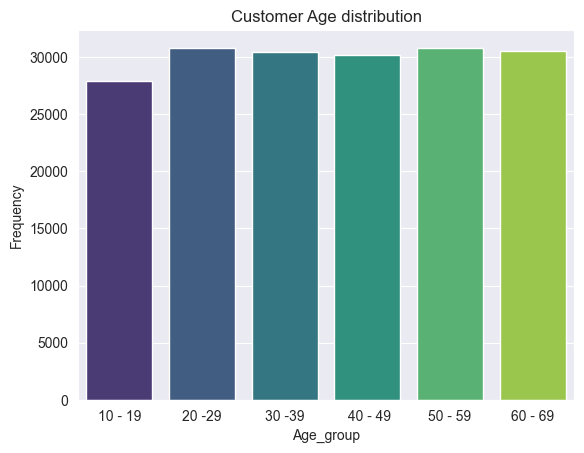

In [96]:

# Age distribution
sns.set_style('darkgrid')
bins  = [10, 20, 30, 40, 50, 60, 70]
labels = ['10 - 19', '20 -29', '30 -39', ' 40 - 49', '50 - 59', '60 - 69']
merged_df['age_group'] = pd.cut(merged_df['age'], bins = bins, labels = labels)
sns.countplot(data = merged_df, x = 'age_group', palette = 'viridis')

plt.xlabel('Age_group')
plt.ylabel('Frequency')
plt.title('Customer Age distribution')

plt.savefig('Graphs/age_hist.png')
plt.show()

C:\Users\DELL XPS\AppData\Local\Temp\ipykernel_19060\1993331942.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged_df, x='age_group', palette='viridis')


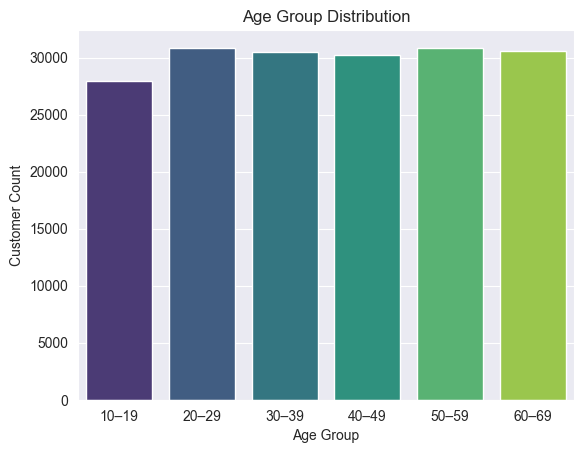

In [93]:
bins = [10, 20, 30, 40, 50, 60, 70]
labels = ['10–19', '20–29', '30–39', '40–49', '50–59', '60–69']
merged_df['age_group'] = pd.cut(merged_df['age'], bins=bins, labels=labels)

sns.countplot(data=merged_df, x='age_group', palette='viridis')
plt.title('Age Group Distribution')
plt.ylabel('Customer Count')
plt.xlabel('Age Group')
plt.show()
